##  Import Libraries

In [1]:
# Import libaries
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

## Import Datasets

We’re taking out new users to make a dataset that feels like a real-world recommender system. We'll still keep the new users in a separate file so we can test how well the system handles both regular and brand-new users.

In [2]:
# read anime dataset
anime = pd.read_csv('./data/anime.csv')
anime.head(5)

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,52991,Sousou no Frieren,2023-09-29,2024-03-22,During their decade-long quest to defeat the D...,9.31,1.0,159,1044444,609185,tv,finished_airing,"Adventure,Drama,Fantasy,Shounen",28,fall,friday,23:00,manga,pg_13,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,2.0,3,3486975,2198350,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
2,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,3.0,14,2671014,1451230,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
3,38524,Shingeki no Kyojin Season 3 Part 2,2019-04-29,2019-07-01,Seeking to restore humanity's diminishing hope...,9.05,4.0,21,2411646,1673369,tv,finished_airing,"Action,Drama,Gore,Military,Shounen,Survival,Su...",10,spring,monday,00:10,manga,r,Wit Studio
4,60022,One Piece Fan Letter,2024-10-20,2024-10-20,Although the golden age of piracy is about to ...,9.05,5.0,2322,93088,70227,tv_special,finished_airing,"Action,Adventure,Fantasy,Shounen",1,fall,NaN,NaN,light_novel,pg_13,Toei Animation


In [3]:
# read user's anime list dataset
user_rating = pd.read_csv('./data/user_ratings.csv', parse_dates=['updated_at'])
user_rating.head(5)

,user_id,anime_id,score,status,num_episodes_watched,updated_at,start_date,finish_date
0,0,58600,0,watching,9,2025-03-07 11:35:25+00:00,2025-01-06,NaN
1,0,22789,10,completed,12,2024-12-17 05:13:44+00:00,2024-10-22,2024-10-23
2,0,20787,0,completed,13,2025-02-22 13:58:28+00:00,2025-02-21,2025-02-22
3,0,52215,0,watching,23,2025-03-03 00:55:37+00:00,2024-10-06,NaN
4,0,57362,0,completed,12,2024-12-24 12:36:39+00:00,2024-10-13,2024-12-24


New Users Dataset: This dataset is purposely made up of only new users to test how each recommender handles cold-start situations. It uses data from Kaggle

In [4]:
# read new user rating
new_user_rating = pd.read_csv('./data/rating_complete.csv')

In [5]:
# keeping column name consistent
new_user_rating = new_user_rating.rename(columns={'rating':'score'})

In [6]:
# number of unique users in new user rating list
new_user_rating.nunique()

user_id     310059
anime_id     16872
score           10
dtype: int64

The New Users Dataset will match the Standard Dataset in size to ensure a fair comparison. In the New Users Dataset, we will take 50% of the users as new users.

In [10]:
# Taking only those user which has watched atleast 20 anime as new users

num_max_users = 125000 # This is to reduce memory usage
new_user_rating = new_user_rating.loc[new_user_rating.user_id <= num_max_users]
group_users = new_user_rating.groupby('user_id')['anime_id'].count().reset_index()
group_new_users = group_users[(group_users['anime_id'] >= 5) & (group_users['anime_id'] <=20)]

# Matching the number of users in standard dataset
target_num_users = user_rating['user_id'].nunique()

# randomly sample users up to the target number
user_to_keep = group_new_users.sample(n=target_num_users, random_state=42)

print(f'Number of users to keep:{len(user_to_keep)} and target number of users: {target_num_users}')

# Keep only select users
new_user_rating = new_user_rating[new_user_rating['user_id'].isin(user_to_keep['user_id'])]
new_user_rating.to_csv('./data/new_users_ratings.csv', index=False)

Number of users to keep:8729 and target number of users: 8729


In [11]:
# dropping these column to make user rating dataset consistent
user_rating.drop(columns=['start_date', 'finish_date'], axis=1, inplace=True)

## Data Pre-processing

#### Checking null values

In [12]:
user_rating.isnull().sum()

user_id                   0
anime_id                  0
score                     0
status                  748
num_episodes_watched      0
updated_at                0
dtype: int64

In [13]:
new_user_rating.isnull().sum()

user_id     0
anime_id    0
score       0
dtype: int64

There is missing value of 748, a score of 0 actually represents a missing rating. On MyAnimeList, users cannot assign a score of 0 unless they choose not to rate the anime.

In [14]:
# Remove users who have only given score 0 or does scored in user rating

def remove_zero_scoring_users(ratings_df: pd.DataFrame):
    users_score_counts = ratings_df.groupby('user_id')['score'].apply(lambda scores: (scores >0).sum())
    users_to_remove = users_score_counts[users_score_counts == 0].index.tolist()
    print(f"Removing {len(users_to_remove)} users who have only 0 scores.")
    
    cleaned_df = ratings_df[~ratings_df.user_id.isin(users_to_remove)].copy()
    
    return cleaned_df

In [15]:
user_rating = remove_zero_scoring_users(user_rating)

Removing 868 users who have only 0 scores.


In [16]:
# Remove Shows without "Completed" Status in user rating

user_rating = user_rating[user_rating['status'] == 'completed']

In [17]:
user_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2439186 entries, 1 to 4253446
Data columns (total 6 columns):
 #   Column                Dtype              
---  ------                -----              
 0   user_id               int64              
 1   anime_id              int64              
 2   score                 int64              
 3   status                object             
 4   num_episodes_watched  int64              
 5   updated_at            datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(4), object(1)
memory usage: 130.3+ MB


In [18]:
# Remove users less than 30 ratings in user rating

def user_rating_less_than30(ratings_df: pd.DataFrame):
    score_counts = ratings_df.groupby('user_id')['score'].count().reset_index()
    users_to_remove = score_counts[score_counts.score < 30].user_id
    print(f"Removing {len(users_to_remove)} users with less than 30 ratings")
    
    cleaned_df = ratings_df[~ratings_df.user_id.isin(users_to_remove)].copy()
    
    return cleaned_df

user_rating = user_rating_less_than30(user_rating)

Removing 741 users with less than 30 ratings


## Exploring  the datasets

In [19]:
# Checking the number of anime watched distribution

def get_histogram(num_watched_group):
    num_watched_data = {
        "0-20": (num_watched_group.between(0, 20)).sum(),
        "21-30": (num_watched_group.between(21, 30)).sum(),
        "31-100": (num_watched_group.between(31, 100)).sum(),
        "101-250": (num_watched_group.between(101, 250)).sum(),
        "251-500": (num_watched_group.between(251, 500)).sum(),
        "501+": (num_watched_group > 500).sum()
    }

    # Plot the bar chart
    sns.barplot(num_watched_data, palette="pastel")
    plt.xlabel('Number of Anime Watched')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Users by Anime Watched')
    
    plt.show()

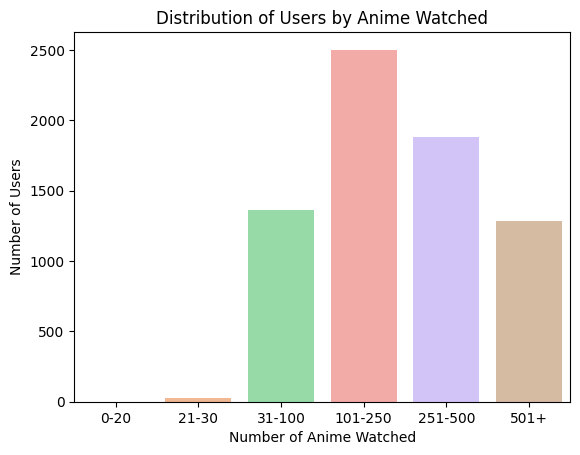

In [20]:
# Standard users
get_histogram((user_rating.groupby('user_id')['anime_id'].count()))

- Users has mostly watched around 100 to 250 animes which is sufficient user-item interactions to detect patterns.

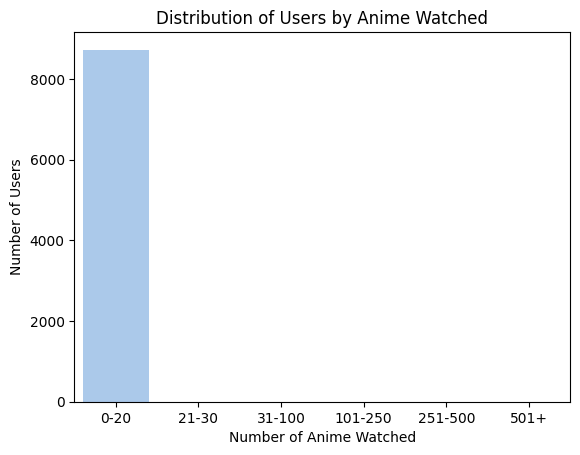

In [21]:
# New Users
get_histogram((new_user_rating.groupby('user_id')['anime_id'].count()))

<Axes: xlabel='score', ylabel='user_id'>

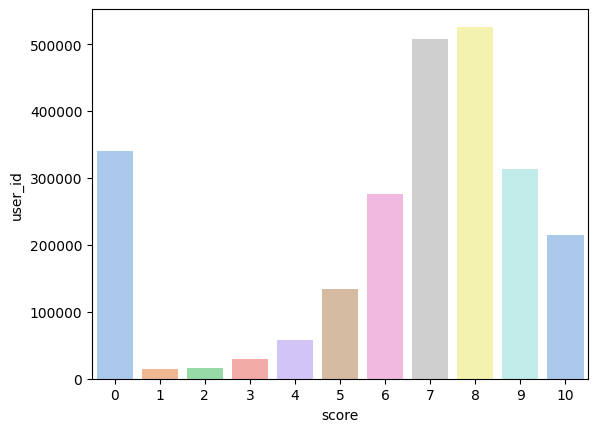

In [22]:
# Checking the score distribution - user rting
sns.barplot(user_rating.groupby('score')['user_id'].count(), palette="pastel")

- Most users rating anime as 8/10 reflects a positive bias, selective engagement, and platform norm

<Axes: xlabel='score', ylabel='user_id'>

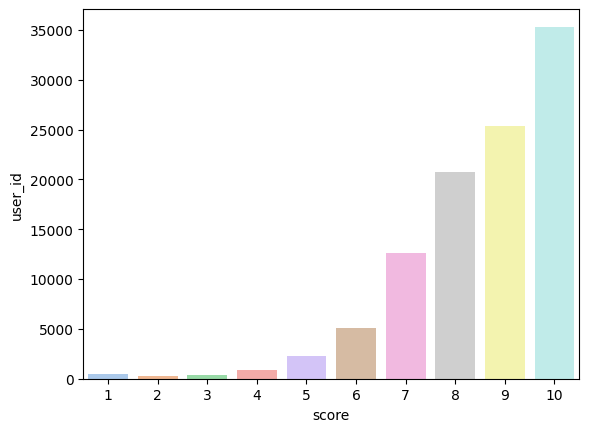

In [23]:
# new user rating
sns.barplot(new_user_rating.groupby('score')['user_id'].count(), palette="pastel")

In [24]:
anime.head(5)

,id,title,start_date,end_date,synopsis,score,rank,popularity,num_list_users,num_scoring_users,media_type,status,genres,num_episodes,start_season,broadcast_day,broadcast_time,source,rating,studios
0,52991,Sousou no Frieren,2023-09-29,2024-03-22,During their decade-long quest to defeat the D...,9.31,1.0,159,1044444,609185,tv,finished_airing,"Adventure,Drama,Fantasy,Shounen",28,fall,friday,23:00,manga,pg_13,Madhouse
1,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,After a horrific alchemy experiment goes wrong...,9.10,2.0,3,3486975,2198350,tv,finished_airing,"Action,Adventure,Drama,Fantasy,Military,Shounen",64,spring,sunday,17:00,manga,r,Bones
2,9253,Steins;Gate,2011-04-06,2011-09-14,Eccentric scientist Rintarou Okabe has a never...,9.07,3.0,14,2671014,1451230,tv,finished_airing,"Drama,Psychological,Sci-Fi,Suspense,Time Travel",24,spring,wednesday,02:05,visual_novel,pg_13,White Fox
3,38524,Shingeki no Kyojin Season 3 Part 2,2019-04-29,2019-07-01,Seeking to restore humanity's diminishing hope...,9.05,4.0,21,2411646,1673369,tv,finished_airing,"Action,Drama,Gore,Military,Shounen,Survival,Su...",10,spring,monday,00:10,manga,r,Wit Studio
4,60022,One Piece Fan Letter,2024-10-20,2024-10-20,Although the golden age of piracy is about to ...,9.05,5.0,2322,93088,70227,tv_special,finished_airing,"Action,Adventure,Fantasy,Shounen",1,fall,NaN,NaN,light_novel,pg_13,Toei Animation


## Creating Train and Test Dataset

In [26]:
split_ratio = 0.8    # 80% of data in training dataset and 20% in test dataset

def train_test_split(ratings_df: pd.DataFrame, split_ratio: float, should_sort = True):
    train_user_ratings = []
    test_user_ratings= []
    
    for user_id in ratings_df['user_id'].unique():
        # sort user by date the rating was last updated
        user_ratings = ratings_df[ratings_df.user_id == user_id]
        
        if should_sort:
            user_ratings = user_ratings.sort_values(by=['updated_at'])
        
        if len(user_ratings) < 2:
            print("ERROR: Not enough ratings to put user in both test and train dataset")
        
        elif len(user_ratings) == 2:
            train_user_ratings.append(user_ratings[user_ratings.index == 0])
            test_user_ratings.append(user_ratings[user_ratings.index == 1])
        else:
            # determine what index to split
            split_index = int(math.floor(len(user_ratings)*split_ratio))
            train_user_ratings.append(user_ratings.iloc[:split_index])
            test_user_ratings.append(user_ratings.iloc[split_index:])
    
    # merged the users data
    train_df = pd.concat(train_user_ratings, ignore_index=True)
    test_df = pd.concat(test_user_ratings, ignore_index=True) 
 
    # Correctly enforce data types
    for col in ['user_id', 'anime_id', 'score']:
        train_df[col] = train_df[col].astype('int32')
        test_df[col] = test_df[col].astype('int32')

    return train_df, test_df
       

In [27]:
# splitting user rating
user_train_df, user_test_df = train_test_split(user_rating, split_ratio)
user_new_train_df, user_new_test_df = train_test_split(new_user_rating, split_ratio, should_sort=False)

In [30]:
print("Standard users train data shape: ", user_train_df.shape)
print("Standard users test data shape: ", user_test_df.shape)
print("New users train data shape: ", user_new_train_df.shape)
print("New users test data shape: ", user_new_test_df.shape)

Standard users train data shape:  (1940952, 6)
Standard users test data shape:  (488734, 6)
New users train data shape:  (79412, 3)
New users test data shape:  (23916, 3)


In [29]:
user_train_df.to_csv('data/user_ratings_train.csv')
user_test_df.to_csv('data/user_ratings_test.csv')
user_new_train_df.to_csv('data/new_user_ratings_train.csv')
user_new_test_df.to_csv('data/new_user_ratings_test.csv')